In [1]:
#Import necessary packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import altair as alt
import sys

In [2]:
#Import necessary packages, functions
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter, save_results, load_results)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring, prim, dimensional_stacking, pairs_plotting
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.samplers
from SALib.analyze import sobol
from SALib.sample import saltelli, morris, fast_sampler
import SALib.util.results
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

def sum_over(*args):
    return sum(args)

In [19]:
#Specify the model
ActorName = 'Gorssel'
dike_model, planning_steps = get_model_for_problem_formulation(ActorName)

## -

In [21]:
#Load in
N_scen = 50
sobol_results = load_results('./results/open_exploration_sobol_' + str(N_scen) + '_'+ ActorName + '.tar.gz')         

[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\results\open_exploration_sobol_3800_Gorssel.tar.gz


In [22]:
sobol_experiments, sobol_outcomes = sobol_results
sobol_outcomes

{'Difference in Expected Annual Damage Gorssel-Deventer': array([0., 0., 0., ..., 0., 0., 0.]),
 'Difference in Expected Number of Deaths Gorssel-Deventer': array([0., 0., 0., ..., 0., 0., 0.]),
 'Gorssel Expected Annual Damage': array([0., 0., 0., ..., 0., 0., 0.]),
 'Gorssel Expected Number of Deaths': array([0., 0., 0., ..., 0., 0., 0.]),
 'Total Costs of Policies': array([1.91802567e+09, 1.91802567e+09, 1.91802567e+09, ...,
        1.72471575e+09, 1.72471575e+09, 1.72471575e+09])}

In [6]:
#Create SALib problem from uncertainties

uncertainties = dike_model.uncertainties
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 37, 'names': ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 2), (0, 133), (30, 350), (0, 3), (0, 11), (0, 11), (0, 11), (0, 1), (30, 350), (0, 3), (0, 11), (0, 11), (0, 11), (0, 1), (30, 350), (0, 3), (0, 11), (0, 11), (0, 11), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [7]:
#Select the Gorssel's chosen outcomes from the sobol results

deaths = sobol_outcomes["Gorssel Expected Annual Damage"]
damage = sobol_outcomes["Gorssel Expected Number of Deaths"]
cost = sobol_outcomes["Total Costs of Policies"]

In [8]:
#Create indices for Expected Number of Deaths

indices_deaths = sobol.analyze(problem, deaths)

In [9]:
#Create indices for Expected Number of Deaths
indices_damage = sobol.analyze(problem, damage)

In [10]:
#Create indices for Expected Number of Deaths
indices_cost = sobol.analyze(problem, cost)

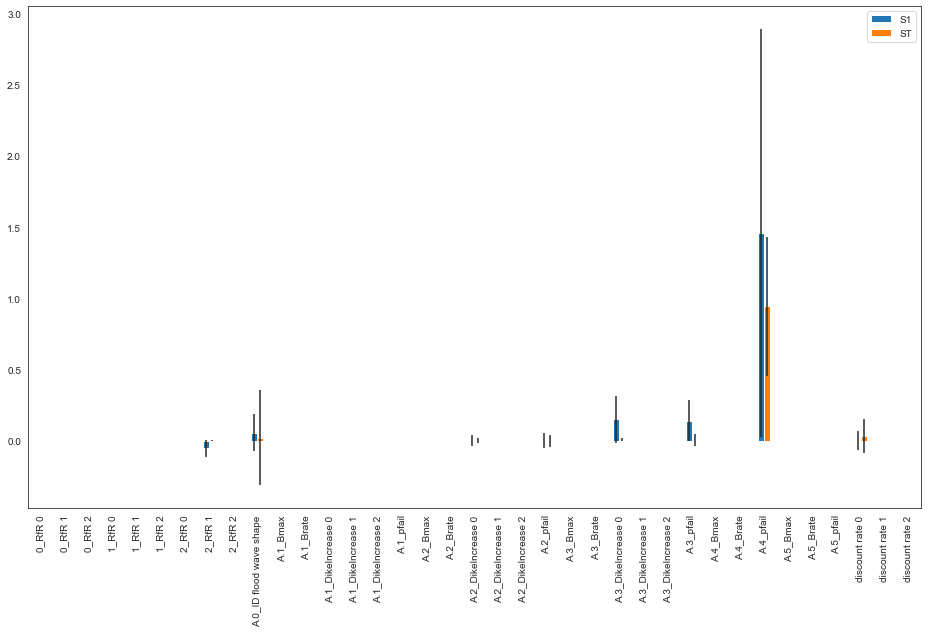

In [11]:
Si_filter = {k:indices_deaths[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(16,12)
fig.subplots_adjust(bottom=0.3)
plt.show()

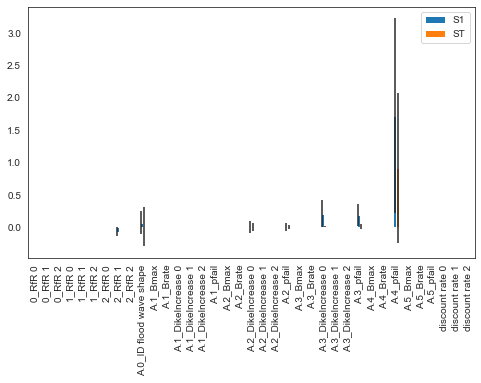

In [12]:
Si_filter = {k:indices_damage[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()


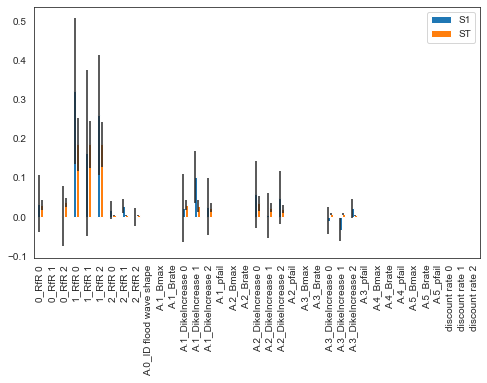

In [13]:
Si_filter = {k:indices_cost[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

# Feature Scoring / Extra Trees

Interpreting these things can be tricky to do for a single actor right? It's pretty much for the whole model, even if we can draw conclusions for individual actors. Idk, I will need to run other actors to test.

[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\results\open_exploration_sobol_3800_Deventer.tar.gz
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\results\open_exploration_sobol_3800_Gorssel.tar.gz
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\David2\\Documents\\GitHub\\FabiosDecisions\\epa1361\\final assignment\\results\\open_exploration_sobol_3800_Overijssel.tar.gz'

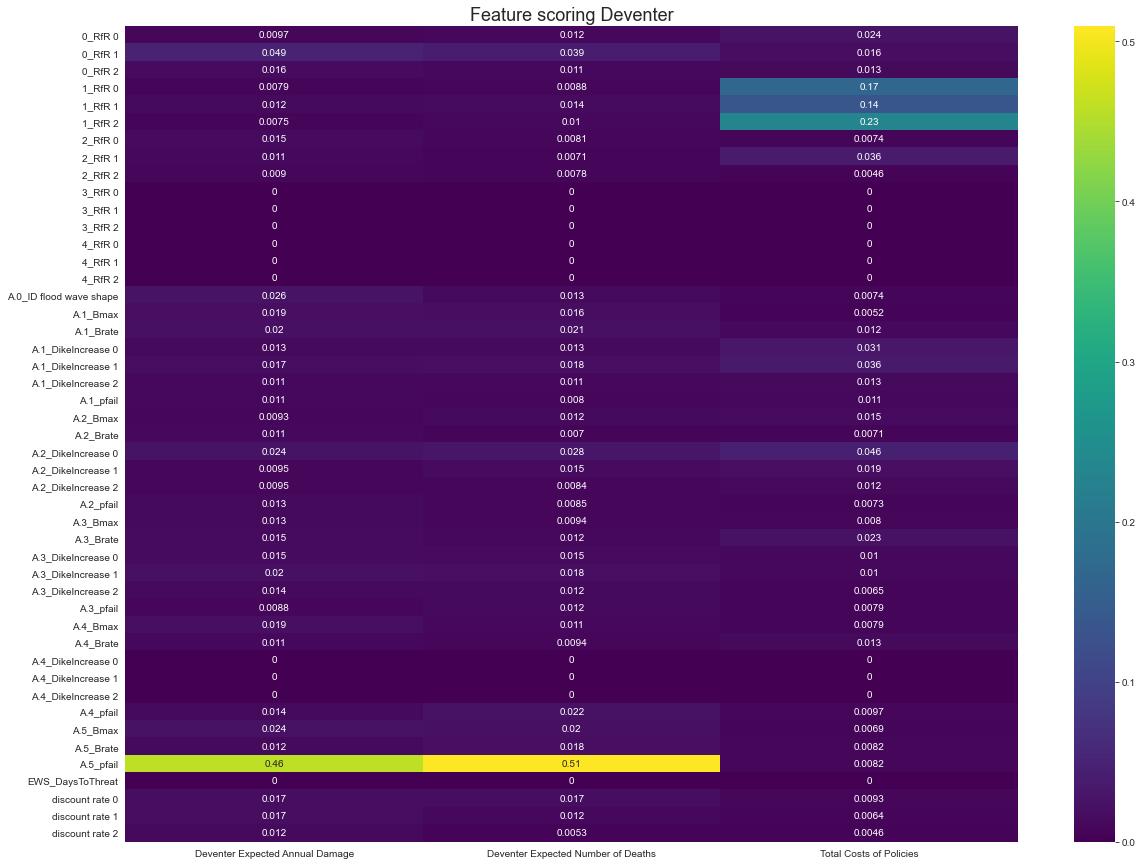

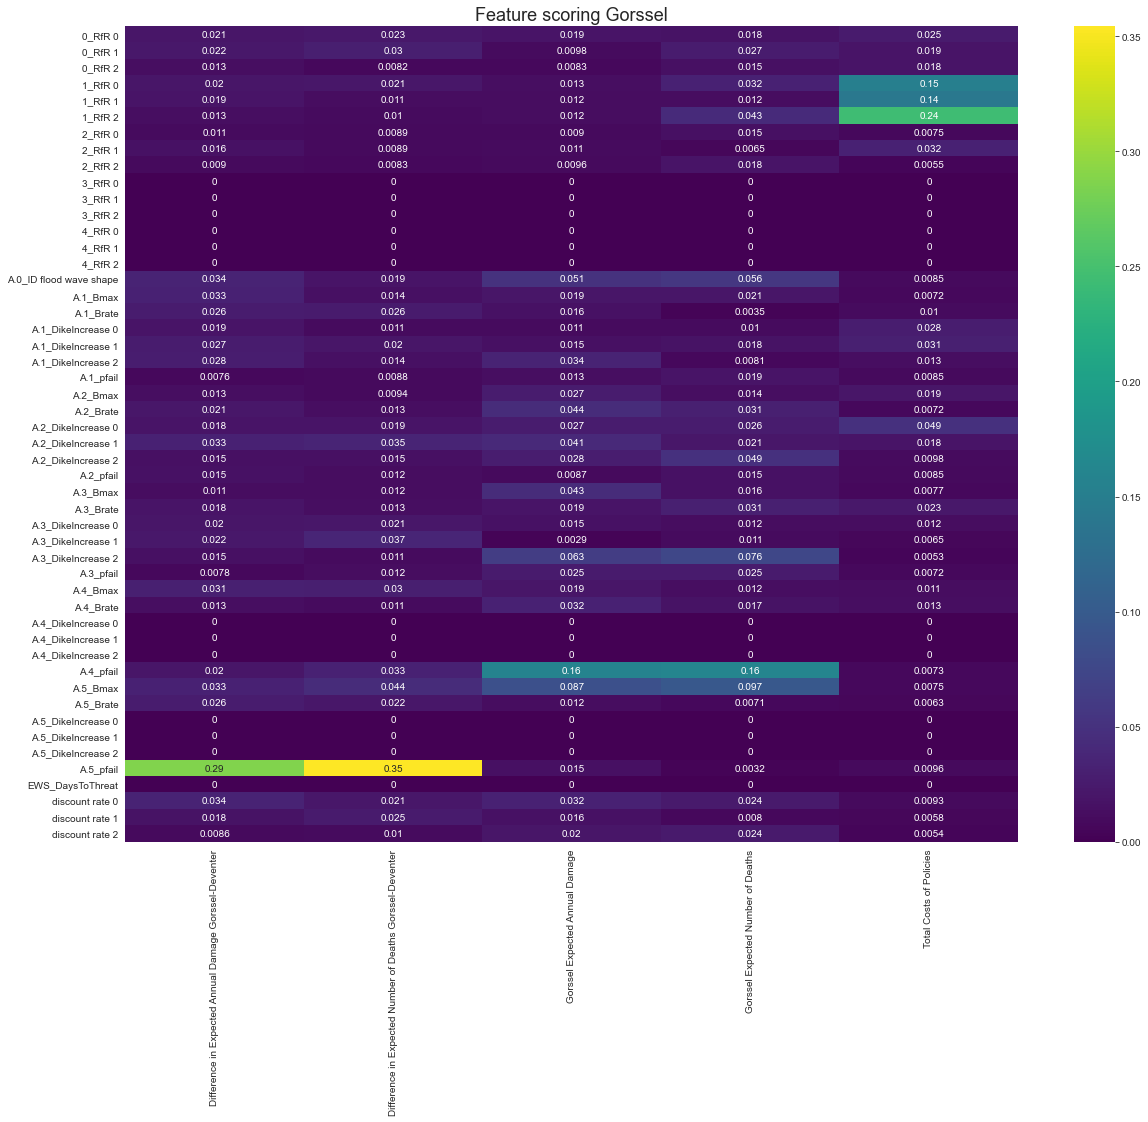

In [28]:
# Generate extra trees for all actors

ActorNames = ['Gorssel', 'Deventer', 'Overijssel']
# ActorNames = ['Gorssel']
N_scen = 50

for ActorName in ActorNames:
    dike_model, planning_steps = get_model_for_problem_formulation(ActorName)
   
    sobol_experiments, sobol_outcomes = load_results('./results/open_exploration_sobol_' + str(N_scen) + '_'+ ActorName + '.tar.gz')       

    x = sobol_experiments
    y = sobol_outcomes
    fs = feature_scoring.get_feature_scores_all(x, y, alg='extra trees')

    # Set up figure
    sns.set_style('white')
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(20,15)


    sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
    ax.set_title('Feature scoring ' + ActorName, fontsize=18)
    
    # Might wanna add to apendices, but better if we make our own visualisation to merge all the actors and show what each one is sensitive to
    plt.savefig('results/visualisations/Feature_scoring_' + ActorName + '.png')
    
plt.show()

It only changes a bit, is that because of randomness or is it a real change? Is it relevant to run for different actors????? I AM CONFUSION.